In [321]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from tqdm import tqdm
import sympy as sym
from scipy.special import lambertw
from scipy.integrate import quad

In [322]:
fold_fig = "C://Users/jujua/Desktop/Retail_T_pdt/Figures_v2/"

## INPUT Real data (conso profile + wholesale prices FR 2024)

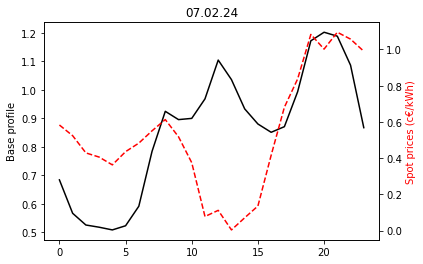

In [323]:
Q3007 = np.array([0.6966,0.5824,0.5355,0.5204,0.5089,0.5222,0.5992,0.7966,0.9284,0.9223,0.9727,
     1.0373,1.1338,1.0789, 0.9816,0.9116,0.8727,0.9187,1.0302,1.2418,1.263,1.2152,1.1099,0.8815])
Q0207=np.array([0.6842,0.5669,0.5258,0.5181,0.5086,0.5232,0.5917,0.7844,0.9248,0.8957,0.9,0.9685,
    1.1046,1.0361,0.9334,0.8803,0.8512,0.8709,0.9933,1.1723,1.2023,1.1885,1.0866,0.8674])
Q1101=np.array([0.8796,0.762,0.7068,0.696,0.6864,0.7056,0.8532,1.128,1.362,1.2876,1.2612,
    1.302,1.4064,1.3116,1.2072,1.1028,1.0944,1.2996,1.6656,1.9668,1.8768,1.6932,1.416,1.092])
Qdic={"01.11.24":Q1101,"07.02.24":Q0207,"07.30.24":Q3007}

plot_day = "07.02.24"

Q=Qdic[plot_day]

c0207 = np.array([0.583,  0.524, 0.429, 0.406, 0.363, 0.436, 0.483, 0.551, 0.613, 0.518, 0.375, 
     0.078, 0.112, 0.004, 0.071, 0.136, 0.416, 0.681, 0.837, 1.083, 1.002 , 1.095, 1.057, 0.990])
c1101 = np.array([0.917,0.886,0.872,0.824,0.806,0.869,0.994,1.17,1.41,1.29,1.14,1.06,0.994,0.99,1.06,
                 1.14,1.07,1.27,1.37,1.32,1.18,1.07,1.00,0.932])
cdic={"01.11.24":c1101,"07.02.24":c0207}
c=cdic[plot_day]
fig,ax1=plt.subplots()
ax1.plot(Q,color='black')
ax1.set_ylabel("Base profile")
ax2=ax1.twinx()
ax2.plot(c,color='red',linestyle="dashed")
ax2.set_ylabel("Spot prices (c€/kWh)",color='red')
plt.title(plot_day)
plt.show()

In [324]:
priceb=np.sum(c*Q)/np.sum(Q)
print(priceb)
varprice = np.sum(Q*(c**2 - priceb**2))/np.sum(Q)
print(varprice)

0.5628079722821544
0.12965540079421872


## BR dynamique

In [325]:
cb = 2
varc=2
pi = 1.85
Q=4

In [326]:
def threshs_pi(_pi,_varc,_lamb,_beta,_cb):
    #poly = X**3 + X**2 *(-_lamb) + X*(-_lamb**2)+_lamb**3 - 4*_lamb**2 * 2*(_cb-_pi)/_varc
    poly = (X-_lamb)**2 * (X+_lamb) - 4*_lamb**2 * 2*(_cb-_pi)/_varc
    roots = sym.solve(poly,X)
    good_roots=[]
    for r in roots:
        if (sym.im(r) < 1e-10 and sym.im(r) > -1e-10):
            good_roots.append(float(sym.re(r).evalf()))
    values_thresh = []
    for r in good_roots:
        if r>=0:
            values_thresh.append(varc*(r+_lamb)/(r-_lamb) * (r-r**2 /_lamb + 2*(_cb-_pi)/_varc))
    values_thresh.append(_cb-_beta*_lamb*_varc/4)
    return values_thresh

In [327]:
X = sym.symbols('X')    

def alpha(_nu,_lamb):
    return (_nu+_lamb)/_lamb

def valid_nu2(_cb,_varc,_lamb,_pi):
    poly = (X-_lamb)**2 * (X+_lamb) - 4*_lamb**2 * 2*(_cb-_pi)/_varc
    roots = sym.solve(poly,X)
    good_roots = []
    for r in roots:
        if (sym.im(r) < 1e-10 and sym.im(r) > -1e-10):
            good_roots.append(float(sym.re(r).evalf()))
    return good_roots

def pb_nu(_cb,_varc,_lamb,_pi):
    nus = valid_nu2(_cb,_varc,_lamb,_pi)
    pbs = []
    for nu in nus:
        pbs.append(_pi+_varc/8 * nu * alpha(nu,_lamb)**2)
    return pbs, nus


def Gd_moins(_Q,_cb,_varc,_lamb,_pi,_beta):
    return (_pi-_cb)*_Q + _beta*_lamb/4*_varc*_Q, 0, _pi


def Gd_plus(_Q,_cb,_varc,_lamb,_pi,_beta):
    pbs,nus = pb_nu(_cb,_varc,_lamb,_pi)
    alphs = alpha(np.array(nus),_lamb)
    Gds=[]
    for i in range(len(nus)):
        a = _Q*_beta*np.exp(-nus[i]/_lamb)*(pbs[i]-_cb)
        b = _beta*(1-alphs[i]/2)*alphs[i]/2 * _varc *(_lamb+nus[i])*np.exp(-nus[i]/_lamb)*_Q
        Gds.append(a+b)
    return Gds, nus, pbs
    
    
def Gd(_Q,_cb,_varc,_lamb,_pi,_beta):
    gds, nu_m, pb_m = Gd_moins(_Q,_cb,_varc,_lamb,_pi,_beta)
    gplus,nuplus,pbplus = Gd_plus(_Q,_cb,_varc,_lamb,_pi,_beta)
    Gds = [gplus[i]*(nuplus[i]>0) for i in range(len(gplus))]+[gds]
    ind_max = np.argmax(Gds)
    threshs = threshs_pi(_pi,_varc,_lamb,_beta,_cb)
    if _pi<=np.min(threshs) or Gds[ind_max]<0:
        return 0, 2*(_cb-_pi)/_varc, _cb
    else:
        if ind_max==len(Gds)-1 :
            return gds, nu_m, pb_m
        else:
            return gplus[ind_max],nuplus[ind_max],pbplus[ind_max]

In [328]:
lambs = np.arange(0.1,10,0.1)

nu_eqs1 = []
pb_eqs1 = []
G_eqs1 = []
nu_eqs01 = []
pb_eqs01 = []
G_eqs01 = []
nu_eqs10 = []
pb_eqs10 = []
G_eqs10 = []

for l in tqdm(lambs):
    a,b,c = Gd(Q,cb,1,l,pi,0.8)
    nu_eqs1.append(b)
    pb_eqs1.append(c)
    G_eqs1.append(a)
    
    a,b,c = Gd(Q,cb,0.1,l,pi,0.8)
    nu_eqs01.append(b)
    pb_eqs01.append(c)
    G_eqs01.append(a)
    
    a,b,c = Gd(Q,cb,10,l,pi,0.8)
    nu_eqs10.append(b)
    pb_eqs10.append(c)
    G_eqs10.append(a)


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [01:03<00:00,  1.57it/s]


In [329]:
def rate(_nus,_pis,_cb,_varc,_lambs):
    res=np.zeros(len(_nus))
    for i in range(len(_nus)):
        res[i] = 1 if _nus[i]==2*(_cb-_pis[i])/_varc else 0.5*(_lambs[i]+_nus[i])/_lambs[i]
    return res

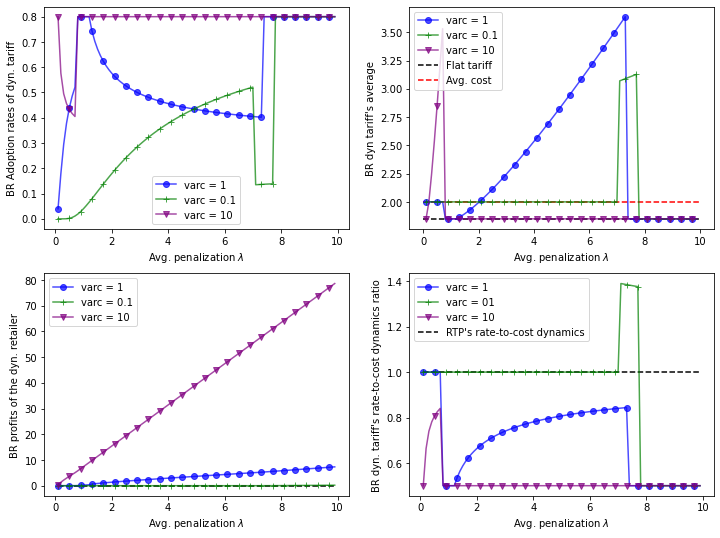

In [330]:
fig,axs=plt.subplots(2,2,figsize=(12,9))
axs[0,0].plot(lambs,0.8*np.exp(-np.array(nu_eqs1)/lambs),label="varc = 1",marker="o",color="blue",markevery=4,alpha=0.7)
axs[0,0].plot(lambs,0.8*np.exp(-np.array(nu_eqs01)/lambs),label="varc = 0.1",marker="+",color="green",markevery=4,alpha=0.7)
axs[0,0].plot(lambs,0.8*np.exp(-np.array(nu_eqs10)/lambs),label="varc = 10",marker="v",color="purple",markevery=4,alpha=0.7)
axs[0,0].set_xlabel(r'Avg. penalization $\lambda$')
axs[0,0].set_ylabel("BR Adoption rates of dyn. tariff")
axs[0,0].legend()
axs[0,1].plot(lambs,pb_eqs1,label="varc = 1",marker="o",color="blue",markevery=4,alpha=0.7)
axs[0,1].plot(lambs,pb_eqs01,label="varc = 0.1",marker="+",color="green",markevery=4,alpha=0.7)
axs[0,1].plot(lambs,pb_eqs10,label="varc = 10",marker="v",color="purple",markevery=4,alpha=0.7)
axs[0,1].set_xlabel(r'Avg. penalization $\lambda$')
axs[0,1].set_ylabel("BR dyn tariff's average")
axs[0,1].hlines(pi,0,10,color='black',linestyle="dashed",label="Flat tariff")
axs[0,1].hlines(cb,0,10,color='red',linestyle="dashed",label="Avg. cost")
axs[0,1].legend()
axs[1,0].plot(lambs,G_eqs1,label="varc = 1",marker="o",color="blue",markevery=4,alpha=0.7)
axs[1,0].plot(lambs,G_eqs01,label="varc = 0.1",marker="+",color="green",markevery=4,alpha=0.7)
axs[1,0].plot(lambs,G_eqs10,label="varc = 10",marker="v",color="purple",markevery=4,alpha=0.7)
axs[1,0].set_xlabel(r'Avg. penalization $\lambda$')
axs[1,0].set_ylabel("BR profits of the dyn. retailer")
axs[1,0].hlines(0,np.min(lambs),np.max(lambs),linestyle="dashed",color="black")
axs[1,0].legend()
axs[1,1].plot(lambs,rate(nu_eqs1,pi*np.ones(len(nu_eqs1)),cb,1,lambs),label="varc = 1",marker="o",color="blue",markevery=4,alpha=0.7)
axs[1,1].plot(lambs,rate(nu_eqs01,pi*np.ones(len(nu_eqs01)),cb,0.1,lambs),label="varc = 01",marker="+",color="green",markevery=4,alpha=0.7)
axs[1,1].plot(lambs,rate(nu_eqs10,pi*np.ones(len(nu_eqs10)),cb,10,lambs),label="varc = 10",marker="v",color="purple",markevery=4,alpha=0.7)
axs[1,1].set_xlabel(r'Avg. penalization $\lambda$')
axs[1,1].set_ylabel("BR dyn. tariff's rate-to-cost dynamics ratio")
axs[1,1].hlines(1,np.min(lambs),np.max(lambs),color="black",linestyle="dashed",label="RTP's rate-to-cost dynamics")
axs[1,1].legend()
#plt.savefig(fold_fig+"BR_dyn_sensib_lambda_varc.pdf")
plt.show()

In [331]:
varc=2
lamb=1
beta=0.8
pis = np.arange(0.011,cb+3,0.01)
nus = []
pbs = []
Gds = []
for pi in tqdm(pis):
    a,b,c = Gd(Q,cb,varc,lamb,pi,beta)
    Gds.append(a)
    pbs.append(c)
    nus.append(b)
pbs_without_uncertainty=np.copy(np.array(pbs))
nus_without_uncertainty=np.copy(np.array(nus))
Gds_without_uncertainty=np.copy(np.array(Gds))

100%|████████████████████████████████████████████████████████████████████████████████| 499/499 [01:03<00:00,  7.80it/s]


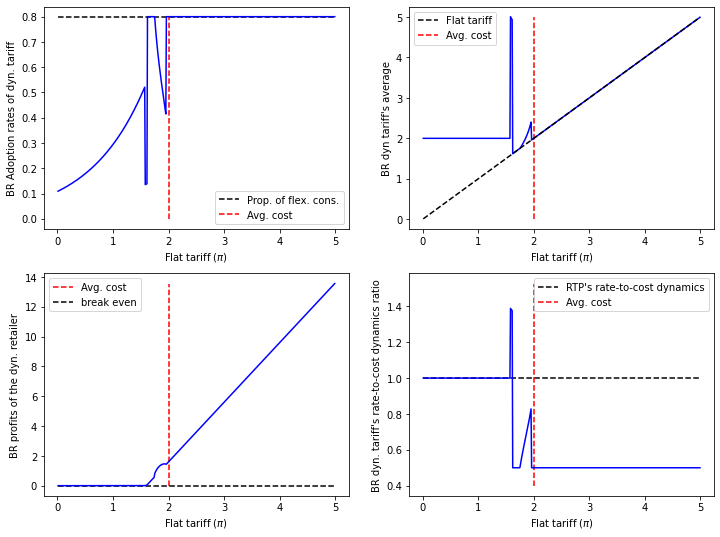

In [332]:
ind_neg = np.where(np.array(Gds)<0)[0]
pis_Gd_negs = pis[ind_neg]

fig,axs=plt.subplots(2,2,figsize=(12,9))

shares=beta*np.exp(-np.array(nus)/lamb)
shares_without_uncertainty = np.copy(shares)
axs[0,0].plot(pis,shares,color="blue")
axs[0,0].fill_between(pis_Gd_negs,0,0.8,color="gray",alpha=0.5)
axs[0,0].set_xlabel(r'Flat tariff ($\pi$)')
axs[0,0].set_ylabel("BR Adoption rates of dyn. tariff")
axs[0,0].hlines(beta,np.min(pis),np.max(pis),label='Prop. of flex. cons.',color='black',linestyle="dashed")
axs[0,0].vlines(cb,0,0.8,label='Avg. cost',color='red',linestyle="dashed")
axs[0,0].legend()

axs[0,1].plot(pis,pbs,color="blue")
axs[0,1].set_xlabel(r'Flat tariff ($\pi$)')
axs[0,1].set_ylabel("BR dyn tariff's average")
axs[0,1].plot(pis,pis,color='black',linestyle="dashed",label='Flat tariff')
axs[0,1].fill_between(pis_Gd_negs,0,np.max(pis),color="gray",alpha=0.5)
axs[0,1].vlines(cb,np.min(pis),np.max(pis),label='Avg. cost',color='red',linestyle="dashed")
axs[0,1].legend()

axs[1,0].plot(pis,Gds,color="blue")
axs[1,0].set_xlabel(r'Flat tariff ($\pi$)')
axs[1,0].set_ylabel("BR profits of the dyn. retailer")
axs[1,0].vlines(cb,np.min(Gds),np.max(Gds),label='Avg. cost',color='red',linestyle="dashed")
axs[1,0].hlines(0,np.min(pis),np.max(pis),color='black',linestyle="dashed",label="break even")
axs[1,0].fill_between(pis_Gd_negs,np.min(Gds),np.max(Gds),color="gray",alpha=0.5)
axs[1,0].legend()

rates = rate(nus,pis,cb,varc,lamb*np.ones(len(nus)))
rates_without_uncertainty = np.copy(rates)
axs[1,1].plot(pis,rates,color="blue") 
axs[1,1].set_xlabel(r'Flat tariff ($\pi$)')
axs[1,1].set_ylabel("BR dyn. tariff's rate-to-cost dynamics ratio")
axs[1,1].hlines(1,np.min(pis),np.max(pis),color="black",linestyle="dashed",label="RTP's rate-to-cost dynamics")
axs[1,1].fill_between(pis_Gd_negs,np.min(rates),np.max(rates),color="gray",alpha=0.5)
axs[1,1].vlines(cb,0.8*np.min(rates),1.1*np.max(rates),label='Avg. cost',color='red',linestyle="dashed")
axs[1,1].legend()

#plt.savefig(fold_fig+"BR_dyn_sensib_pi.pdf")
plt.show()

## BR flat tariff

In [333]:
cb0 = 2
Q=4
lamb=3
beta=0.8

In [334]:
def br_pi(_pb,_varp,_lamb,_cb0,_beta):
    mid_pi = _cb0 - _lamb*_varp/2 + _lamb*_varp/2 * np.real(lambertw(1/_beta * np.exp(1+2*(_pb-_cb0)/(_lamb*_varp))))
    pi_res = np.max([_cb0,np.min([_pb,mid_pi])])
    nu = 2*(_pb-pi_res)/_varp
    return pi_res, nu

def Gf(_Q,_pb,_varp,_lamb,_cb0,_beta):
    pi, nu = br_pi(_pb,_varp,_lamb,_cb0,_beta)
    if nu>=0:
        return (pi-_cb0)*_Q*(1-_beta+_beta*(1-np.exp(-nu/_lamb))),nu,pi
    else:
        return 0,nu,pi

In [335]:
varp=2
pbs = np.arange(0.1,cb0+3,0.1)

Gfs=[]
Gfs01=[]
Gfs10=[]
nus=[]
nus01=[]
nus10=[]
adops=[]
adops01=[]
adops10=[]
pis=[]
pis01=[]
pis10=[]
for pb in tqdm(pbs):
    gf,n,pii = Gf(Q,pb,varp,lamb,cb0,beta)
    Gfs.append(gf)
    nus.append(n)
    pis.append(pii)
    ad = 1-beta*np.exp(-n/lamb) if n >=0 else 0
    adops.append(ad)
    
    gf,n,pii = Gf(Q,pb,0.1,lamb,cb0,beta)
    Gfs01.append(gf)
    nus01.append(n)
    ad = 1-beta*np.exp(-n/lamb) if n >=0 else 0
    adops01.append(ad)
    pis01.append(pii)
    
    gf,n,pii = Gf(Q,pb,10,lamb,cb0,beta)
    Gfs10.append(gf)
    nus10.append(n)
    ad = 1-beta*np.exp(-n/lamb) if n >=0 else 0
    adops10.append(ad)
    pis10.append(pii)
    
pis_without_uncertainty = np.copy(np.array(pis))

100%|██████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<?, ?it/s]


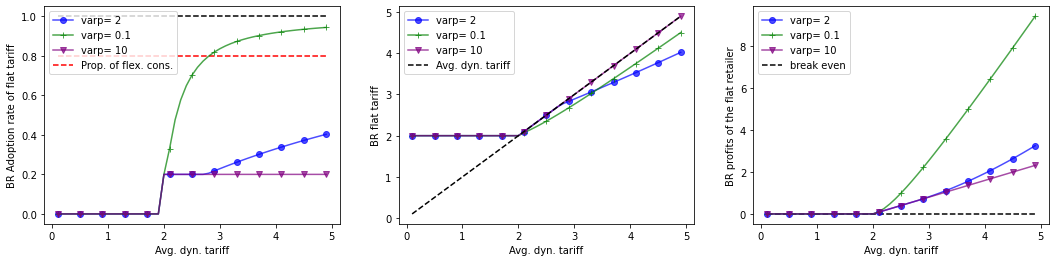

In [336]:
fig,axs=plt.subplots(1,3,figsize=(18,4))

axs[0].plot(pbs,adops,label="varp= 2",marker="o",color="blue",markevery=4,alpha=0.7)
axs[0].plot(pbs,adops01,label="varp= 0.1",marker="+",color="green",markevery=4,alpha=0.7)
axs[0].plot(pbs,adops10,label="varp= 10",marker="v",color="purple",markevery=4,alpha=0.7)
axs[0].hlines(1,np.min(pbs),np.max(pbs),color="black",linestyle="dashed")
axs[0].hlines(beta,np.min(pbs),np.max(pbs),color="red",linestyle="dashed",label="Prop. of flex. cons.")
axs[0].set_xlabel("Avg. dyn. tariff")
axs[0].set_ylabel("BR Adoption rate of flat tariff")
axs[0].legend()

axs[1].plot(pbs,pis,label="varp= 2",marker="o",color="blue",markevery=4,alpha=0.7)
axs[1].plot(pbs,pis01,label="varp= 0.1",marker="+",color="green",markevery=4,alpha=0.7)
axs[1].plot(pbs,pis10,label="varp= 10",marker="v",color="purple",markevery=4,alpha=0.7)
axs[1].plot(pbs,pbs,color='black',linestyle="dashed",label="Avg. dyn. tariff")
axs[1].set_xlabel("Avg. dyn. tariff")
axs[1].set_ylabel("BR flat tariff")
axs[1].legend()

axs[2].plot(pbs,Gfs,label="varp= 2",marker="o",color="blue",markevery=4,alpha=0.7)
axs[2].plot(pbs,Gfs01,label="varp= 0.1",marker="+",color="green",markevery=4,alpha=0.7)
axs[2].plot(pbs,Gfs10,label="varp= 10",marker="v",color="purple",markevery=4,alpha=0.7)
axs[2].set_xlabel("Avg. dyn. tariff")
axs[2].set_ylabel("BR profits of the flat retailer")
axs[2].hlines(0,np.min(pbs),np.max(pbs),color='black',linestyle="dashed",label="break even")
axs[2].legend()
#plt.savefig(fold_fig+"BR_flat_sensib_pb.pdf")
plt.show()

## Iteration of best responses

System's parameters:
 	 Q: 49.3416
 	 cb: 0.87917576041312
 	 cb0:0.87917576041312
 	 varc: 0.07020442264086002
 	 lambda: 0.5
 	 beta: 0.8


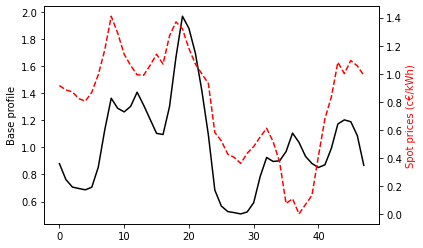

In [337]:
# Params system
lamb = 0.5
beta=0.8
#D=24h
days = ["01.11.24","07.02.24"]
Q=0
cb=0
for d in range(len(days)):
    Q += np.sum(Qdic[days[d]])
    cb += np.sum(Qdic[days[d]]*cdic[days[d]])
cb = cb/Q
cb0 = cb

c=np.zeros(24*len(days))
Qs=np.zeros(24*len(days))
for m in range(len(days)):
    for t in range(24):
        c[t+24*m]=cdic[days[m]][t]
        Qs[t+24*m]=Qdic[days[m]][t]
        
cms = np.zeros(len(days))
Qms = np.zeros(len(days))
for d in range(len(days)):
    Qms[d] = np.sum(Qdic[days[d]])
    cms[d] = np.sum(Qdic[days[d]]*cdic[days[d]])/Qms[d]
ext_cms = np.zeros(24*len(days))
for d in range(len(days)):
    for t in range(24):
        ext_cms[t+24*d] = cms[d]
    
varc = 0
for d in range(len(days)):
    for t in range(24):
        varc += Qs[t+24*d]*(c[t+24*d]**2 - ext_cms[t+24*d]**2)
varc=varc/Q

#cb=2
#varc=2

print("System's parameters:\n \t Q: %s\n \t cb: %s\n \t cb0:%s\n \t varc: %s\n \t lambda: %s\n \t beta: %s"%(Q,cb,cb0,varc,lamb,beta))


fig,ax1=plt.subplots()
ax1.plot(Qs,color='black')
ax1.set_ylabel("Base profile")
ax2=ax1.twinx()
ax2.plot(c,color='red',linestyle="dashed")
ax2.set_ylabel("Spot prices (c€/kWh)",color='red')
plt.show()

In [338]:
def convergence(_Q,_pb0,_varp0,_lamb,_cb0,_cb,_varc,_beta,NB_ITER,tol=1e-5):
    # containers
    pis = []
    pbs = []
    varps = []
    nu_flat = []
    nu_dyn = []
    prof_dyn = []
    prof_flat = []
    
    #Initialisation avec le RTP
    pbs.append(_pb0)
    varps.append(_varp0) 
    
    # Iterations des meilleures reponses
    for it in tqdm(range(NB_ITER)):
        proff, nf, pi = Gf(_Q,pbs[-1],varps[-1],_lamb,_cb0,_beta)
        nu_flat.append(nf)
        pis.append(pi)
        prof_flat.append(proff)
        profd, nd, pb = Gd(_Q,_cb,_varc,_lamb,pis[-1],_beta)
        nu_dyn.append(nd)
        pbs.append(pb)
        prof_dyn.append(profd)
        varps.append(((nd+_lamb)/_lamb)**2 / 4 * _varc)
        
        
        if it >5 and np.mean(np.abs(np.array(nu_dyn[-5:])-np.array(nu_flat[-5:]))) <= tol:
            print("Equilibrium reached - iteration %s / %s"%(it,NB_ITER))
            return np.array(pis), np.array(nu_flat), np.array(pbs), np.array(varps), np.array(nu_dyn),  np.array(prof_flat), np.array(prof_dyn)
        
    print("No equilibrium after %s iterations"%NB_ITER)
    return np.array(pis), np.array(nu_flat), np.array(pbs), np.array(varps), np.array(nu_dyn), np.array(prof_flat), np.array(prof_dyn)
    

In [339]:
pis, nu_flat, pbs, varps, nu_dyn, prof_flat, prof_dyn = convergence(Q,cb,2*varc,lamb,cb0,cb,varc,beta,200)

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]C:\Users\jujua\AppData\Local\Temp/ipykernel_25068/4083273400.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  values_thresh.append(varc*(r+_lamb)/(r-_lamb) * (r-r**2 /_lamb + 2*(_cb-_pi)/_varc))
C:\Users\jujua\AppData\Local\Temp/ipykernel_25068/4083273400.py:12: RuntimeWarning: invalid value encountered in double_scalars
  values_thresh.append(varc*(r+_lamb)/(r-_lamb) * (r-r**2 /_lamb + 2*(_cb-_pi)/_varc))
  3%|██▍                                                                               | 6/200 [00:00<00:13, 14.06it/s]

Equilibrium reached - iteration 6 / 200


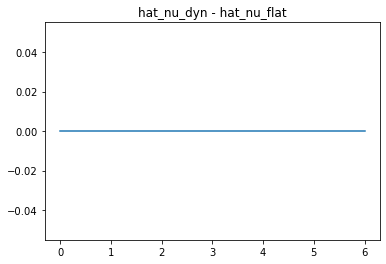

In [340]:
plt.figure()
plt.plot(nu_dyn-nu_flat)
plt.title("hat_nu_dyn - hat_nu_flat")
plt.show()

In [341]:
print(nu_dyn[-1])
print(nu_flat[-1])

0
0.0


In [342]:
np.exp(-nu_dyn[-1]/lamb)-np.exp(-nu_flat[-1]/lamb)

0.0

In [343]:
print("Equilibrium:\n \t flat tariff : %s\n \t flat tariff avg cost: %s\n \t avg dyn tariff: %s\n \t dyn tariff-to-cost ratio: %s\n \t dyn adoption rate: %s  "%(pis[-1],cb0,pbs[-1],0.5*(nu_flat[-1]/lamb +1), beta*np.exp(-nu_flat[-1]/lamb)))


Equilibrium:
 	 flat tariff : 0.87917576041312
 	 flat tariff avg cost: 0.87917576041312
 	 avg dyn tariff: 0.87917576041312
 	 dyn tariff-to-cost ratio: 0.5
 	 dyn adoption rate: 0.8  


In [344]:
def dyn_tariff_profile(_pb,_nu,_lamb,_c,_cms):
    profile = np.zeros(24*len(days))
    for d in range(len(days)):
        for t in range(24):
            profile[t+24*d] = (_nu+_lamb)/_lamb * 0.5 * (_c[t+24*d]-_cms[d]) + _pb
    return profile

def net_revenues_profile_dyn(tariff_profile,_c,_nu,_lamb):
    profile = np.zeros(24*len(days))
    tariff_m = np.zeros(len(days))
    for d in range(len(days)):
        tariff_m[d] = np.sum(tariff_profile[24*d:24*(d+1)-1]*Qs[24*d:24*(d+1)-1])/Qms[d]
    share_flex = beta*np.exp(-_nu/_lamb)
    exp_flex = beta*(_nu+_lamb)*np.exp(-_nu/_lamb)
    for d in range(len(days)):
        for t in range(24):
            profile[t+24*d] = Qs[t+24*d]*(tariff_profile[t+24*d]-_c[t+24*d])*share_flex - exp_flex*Qs[t+24*d]*(tariff_profile[t+24*d]-_c[t+24*d])*(tariff_profile[t+24*d]-tariff_m[d])
    return profile

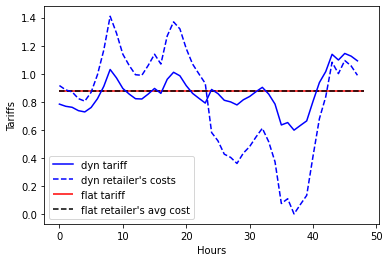

In [345]:
ps = dyn_tariff_profile(pbs[-1],nu_dyn[-1],lamb,c,cms)
pms = np.zeros(len(days))
for d in range(len(days)):
    pms[d] = np.sum(ps[24*d:24*(d+1)-1]*Qs[24*d:24*(d+1)-1])/Qms[d]
ext_pms = np.zeros(24*len(days))
for d in range(len(days)):
    for t in range(24):
        ext_pms[t+24*d] = pms[d]
plt.figure()
plt.plot(ps,label="dyn tariff",color="blue")
plt.hlines(pis[-1],0,24*len(days),label="flat tariff",color="red")
plt.plot(c,label="dyn retailer's costs",color="blue",linestyle="dashed")
plt.hlines(cb0,0,24*len(days),label="flat retailer's avg cost",color="black",linestyle="dashed")
plt.xlabel("Hours")
plt.ylabel("Tariffs")
plt.legend()
#plt.savefig(fold_fig+"equilibrium_tariff_equal_scosts.pdf")
plt.show()

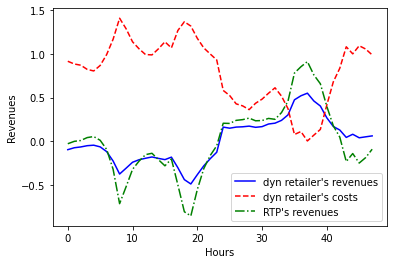

In [346]:
revenues = net_revenues_profile_dyn(ps,c,nu_dyn[-1],lamb)
plt.figure()
plt.plot(revenues,label="dyn retailer's revenues",color="blue")
plt.plot(c,label="dyn retailer's costs",color="red",linestyle="dashed")
plt.plot(Qs*(np.sum(revenues)/Q+cb-c),label="RTP's revenues",color="green",linestyle="-.")
plt.legend()
plt.xlabel("Hours")
plt.ylabel("Revenues")
#plt.savefig(fold_fig+"equilibrium_revenues_equal_scosts.pdf")
plt.show()

In [347]:
print("Revenu total du retailer dynamique: %.2f"%np.sum(revenues))
print("Ecart type du revenu instantanné en pourcentage du revenu: %.2f pct"%(np.std(revenues)/np.sum(revenues) *100))
print("Ecart type d'un revenu flat a cb en pourcentage du revenu (revenu egal): %.2f pct"%(np.std(Qs*(np.sum(revenues)/Q+cb-c))/np.sum(revenues) *100))

Revenu total du retailer dynamique: 0.30
Ecart type du revenu instantanné en pourcentage du revenu: 84.05 pct
Ecart type d'un revenu flat a cb en pourcentage du revenu (revenu egal): 131.59 pct


In [348]:
def aggregate_load(dyn_tariff_profile, dyn_avg_period, _nu,_lamb):
    res = np.zeros(24*len(days))
    for d in range(len(days)):
        for t in range(24):
            res[t+24*d] = Qs[t+24*d]* (1 - beta*(_nu+_lamb)*np.exp(-_nu/_lamb)* (dyn_tariff_profile[t+24*d] - dyn_avg_period[d])   )
    return res
    
def full_RTP_load(_c,_cms,_lamb):
    res = np.zeros(24*len(days))
    for d in range(len(days)):
        for t in range(24):
            res[t+24*d] = Qs[t+24*d]* (1 - beta*_lamb* (_c[t+24*d] - _cms[d])   )
    return res
    

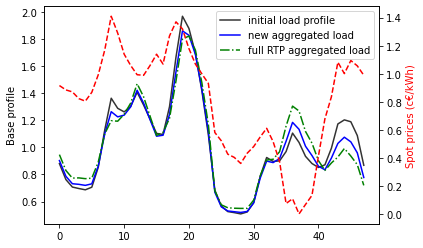

In [349]:
modif_load = aggregate_load(ps,pms,nu_dyn[-1],lamb)
full_rtp = full_RTP_load(c,cms,lamb)
fig,ax1=plt.subplots()
ax1.plot(Qs,color='black',alpha=0.8,label="initial load profile")
ax1.plot(modif_load,color="blue",label="new aggregated load")
ax1.plot(full_rtp,color="green",linestyle="-.",label="full RTP aggregated load")
ax1.set_ylabel("Base profile")
ax2=ax1.twinx()
ax2.plot(c,color='red',linestyle="dashed")
ax2.set_ylabel("Spot prices (c€/kWh)",color='red')
ax1.legend()
#plt.savefig(fold_fig+"equilibrium_load_equal_scosts.pdf")
plt.show()

In [350]:
print("Ecart type de la charge en pct de la charge totale: \n\t initiale : %.2f\n\t en competition: %.2f\n\t full RTP: %.2f"%(np.std(Qs)/Q*100,np.std(modif_load)/Q*100,np.std(full_rtp)/Q*100))

Ecart type de la charge en pct de la charge totale: 
	 initiale : 0.70
	 en competition: 0.66
	 full RTP: 0.65


In [351]:
def consumer_surplus(_nu,_pi,_pb,_lamb,_beta,_varc,_Q):
    if _nu<=0:
        return -_pi*Q*(1-_beta) + _beta*_lamb/8 * _varc*_Q - _pb*_Q*_beta 
    else:
        return -pi*_Q*(1-_beta*np.exp(-_nu/_lamb))-_beta*np.exp(-_nu/_lamb)*_pb*_Q + _beta/8 *_varc*_Q *(_nu+_lamb)**3 /_lamb**2 *np.exp(-_nu/_lamb)
    
def consumer_surplus_full_rtp(_c,_cb,_beta,_varc,_lamb,_Q):
    return -_cb*_Q + _beta*_lamb/2 * _varc*_Q 

def consumer_surplus_full_reg_flat(_cb,_Q):
    return -_cb*_Q  

In [352]:
print(consumer_surplus(nu_dyn[-1],pis[-1],pbs[-1],lamb,beta,varc,Q))
print(consumer_surplus_full_rtp(c,cb,beta,varc,lamb,Q))
print(consumer_surplus_full_reg_flat(cb,Q))

-43.20673877299119
-42.687138991964744
-43.3799387


In [353]:
# enchainement des test en fcn de cb0/cb

In [354]:
coeffs = np.arange(0.01,2,0.5)
nu_fin_flat = np.zeros(len(coeffs))
nu_fin_dyn = np.zeros(len(coeffs))

for i,coeff in enumerate(coeffs):
    pis, nu_flat, pbs, varps, nu_dyn, prof_flat, prof_dyn = convergence(Q,cb,2*varc,lamb,cb*coeff,cb,varc,beta,100)
    nu_fin_flat[i] = nu_flat[-1]
    nu_fin_dyn[i] = nu_dyn[-1]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.08it/s]


No equilibrium after 100 iterations


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.91it/s]


No equilibrium after 100 iterations


  6%|████▉                                                                             | 6/100 [00:01<00:18,  5.01it/s]


Equilibrium reached - iteration 6 / 100


  6%|████▉                                                                             | 6/100 [00:01<00:17,  5.36it/s]

Equilibrium reached - iteration 6 / 100


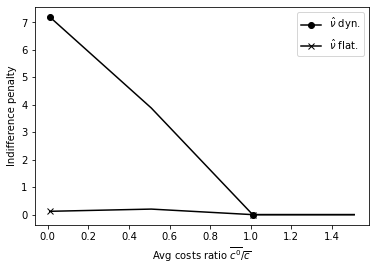

In [355]:
plt.figure()
plt.plot(coeffs,nu_fin_dyn,label=r'$\hat{\nu}$ dyn.',color="black",marker="o",markevery=2)
plt.plot(coeffs,nu_fin_flat,label=r'$\hat{\nu}$ flat.',color="black",marker="x",markevery=2)
plt.xlabel(r'Avg costs ratio $\overline{c^0}/\overline{c}$')
plt.ylabel("Indifference penalty")
plt.legend()
#plt.savefig(fold_fig+"nu_eq_cost_ratio.pdf")
plt.show()

## Ex-ante uncertainty in tariffs

### BR dynamic retailer

In [356]:
def gam(_mu,_sig2):
    return _mu/(_mu**2 + _sig2)
X = sym.symbols('X')    

def alphatild(_nu,_lamb,_gam):
    return (_gam*_nu+_lamb)/(_lamb+(_gam-1)*_nu)

def valid_nu_new(_cb,_varc,_lamb,_pi,_gam):
    a3 = (4*_gam-5)*_gam**2
    a2 = (5*_gam-4)*_gam*_lamb - 4*(_gam-1)**2 *_gam * 2*(_cb-_pi)/_varc  
    a1 = _gam*_lamb**2 - 8*_gam*(_gam-1)*_lamb* 2*(_cb-_pi)/_varc 
    a0 = -_lamb**3 - 4*_lamb**2 * _gam * 2*(_cb-_pi)/_varc
    poly = X**3 * a3  + X**2 * a2  + X* a1 + a0
    roots = sym.solve(poly,X)
    good_roots = []
    for r in roots:
        if (sym.im(r) < 1e-10 and sym.im(r) > -1e-10):
            good_roots.append(float(sym.re(r).evalf()))
    return good_roots

def pb_nu_new(_cb,_varc,_lamb,_pi,_gam):
    nus = valid_nu_new(_cb,_varc,_lamb,_pi,_gam)
    pbs = []
    for nu in nus:
        pbs.append(_pi+_varc/8 * nu * alphatild(nu,_lamb,_gam)**2)
    return pbs, nus


def Gd_moins_new(_Q,_cb,_varc,_lamb,_pi,_beta):
    return (_pi-_cb)*_Q + _beta*_lamb/4*_varc*_Q, 0, _pi

def Gd_plus_new(_Q,_cb,_varc,_lamb,_pi,_beta,_gam):
    pbs,nus = pb_nu_new(_cb,_varc,_lamb,_pi,_gam)
    alphs = alphatild(np.array(nus),_lamb,_gam)
    Gds=[]
    for i in range(len(nus)):
        a = _Q*_beta*np.exp(-_gam*nus[i]/_lamb)*(pbs[i]-_cb)
        b = _beta*(1-alphs[i]/2)*alphs[i]/2 * _varc *(_lamb+_gam*nus[i])*np.exp(-_gam*nus[i]/_lamb)*_Q
        Gds.append(a+b)
    return Gds, nus, pbs

def threshs_pi_new(_pi,_varc,_lamb,_beta,_cb,_gam):
    a3 = (4*_gam-5)*_gam**2
    a2 = (5*_gam-4)*_gam*_lamb - 4*(_gam-1)**2 *_gam * 2*(_cb-_pi)/_varc  
    a1 = _gam*_lamb**2 - 8*_gam*(_gam-1)*_lamb* 2*(_cb-_pi)/_varc 
    a0 = -_lamb**3 - 4*_lamb**2 * _gam * 2*(_cb-_pi)/_varc
    poly = X**3 * a3  + X**2 * a2  + X* a1 + a0
    roots = sym.solve(poly,X)
    good_roots=[]
    for r in roots:
        if (sym.im(r) < 1e-10 and sym.im(r) > -1e-10):
            good_roots.append(float(sym.re(r).evalf()))
    values_thresh = []
    for r in good_roots:
        if r>=0:
            al = (_gam*r+_lamb) / (_lamb+ r*(_gam-1))
            bout1 = (al/2 -1)*al/2 *_varc *(_lamb+_gam*r)
            bout2 = -_varc/8 * r * al**2
            values_thresh.append(bout1+bout2)
    values_thresh.append(_cb-_beta*_lamb*_varc/4)
    return values_thresh

def Gd_new(_Q,_cb,_varc,_lamb,_pi,_beta,_gam):
    gds, nu_m, pb_m = Gd_moins_new(_Q,_cb,_varc,_lamb,_pi,_beta)
    gplus,nuplus,pbplus = Gd_plus_new(_Q,_cb,_varc,_lamb,_pi,_beta,_gam)
    Gds = [gplus[i]*(nuplus[i]>0) for i in range(len(gplus))]+[gds]
    ind_max = np.argmax(Gds)
    threshs = threshs_pi_new(_pi,_varc,_lamb,_beta,_cb,_gam)
    if _pi<=np.min(threshs) or Gds[ind_max]<0:
        return 0, 2*(_cb-_pi)/_varc, _cb
    else:
        if ind_max==len(Gds)-1 :
            return gds, nu_m, pb_m
        else:
            return gplus[ind_max],nuplus[ind_max],pbplus[ind_max]

In [357]:
def rate_new(_nus,_pis,_cb,_varc,_lambs,_gam):
    res=np.zeros(len(_nus))
    for i in range(len(_nus)):
        res[i] = 1 if _nus[i]==2*(_cb-_pis[i])/_varc else 0.5*(_gam*_nus[i]+_lambs[i])/(_lambs[i]+(_gam-1)*_nus[i])
    return res

In [358]:
mu = 1.2
s2 = 1
gamma = gam(mu,s2)

cb = 2
varc=2
pi = 1.85
Q=4

In [359]:
lambs = np.arange(0.1,10,0.1)

nu_eqs1_new = []
pb_eqs1_new = []
G_eqs1_new = []
nu_eqs01_new = []
pb_eqs01_new = []
G_eqs01_new = []
nu_eqs10_new = []
pb_eqs10_new = []
G_eqs10_new = []

for l in tqdm(lambs):
    a,b,c = Gd_new(Q,cb,1,l,pi,0.8,gamma)
    nu_eqs1_new.append(b)
    pb_eqs1_new.append(c)
    G_eqs1_new.append(a)
    
    a,b,c = Gd_new(Q,cb,0.1,l,pi,0.8,gamma)
    nu_eqs01_new.append(b)
    pb_eqs01_new.append(c)
    G_eqs01_new.append(a)
    
    a,b,c = Gd_new(Q,cb,10,l,pi,0.8,gamma)
    nu_eqs10_new.append(b)
    pb_eqs10_new.append(c)
    G_eqs10_new.append(a)

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [02:02<00:00,  1.24s/it]


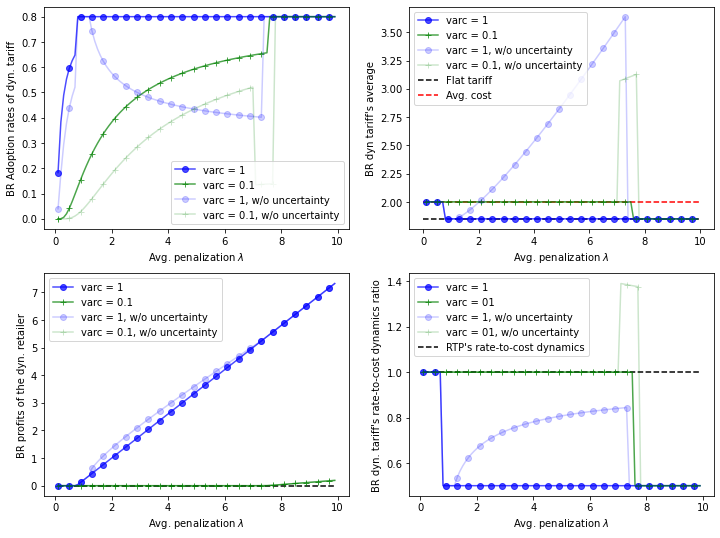

In [360]:
fig,axs=plt.subplots(2,2,figsize=(12,9))
axs[0,0].plot(lambs,0.8*np.exp(-gamma*np.array(nu_eqs1_new)/lambs),label="varc = 1",marker="o",color="blue",markevery=4,alpha=0.7)
axs[0,0].plot(lambs,0.8*np.exp(-gamma*np.array(nu_eqs01_new)/lambs),label="varc = 0.1",marker="+",color="green",markevery=4,alpha=0.7)
#axs[0,0].plot(lambs,0.8*np.exp(-gamma*np.array(nu_eqs10_new)/lambs),label="varc = 10",marker="v",color="purple",markevery=4,alpha=0.7)

axs[0,0].plot(lambs,0.8*np.exp(-np.array(nu_eqs1)/lambs),label="varc = 1, w/o uncertainty",marker="o",color="blue",markevery=4,alpha=0.2)
axs[0,0].plot(lambs,0.8*np.exp(-np.array(nu_eqs01)/lambs),label="varc = 0.1, w/o uncertainty",marker="+",color="green",markevery=4,alpha=0.2)
#axs[0,0].plot(lambs,0.8*np.exp(-np.array(nu_eqs10)/lambs),label="varc = 10, w/o uncertainty",marker="v",color="purple",markevery=4,alpha=0.2)

axs[0,0].set_xlabel(r'Avg. penalization $\lambda$')
axs[0,0].set_ylabel("BR Adoption rates of dyn. tariff")
axs[0,0].legend()

axs[0,1].plot(lambs,pb_eqs1_new,label="varc = 1",marker="o",color="blue",markevery=4,alpha=0.7)
axs[0,1].plot(lambs,pb_eqs01_new,label="varc = 0.1",marker="+",color="green",markevery=4,alpha=0.7)
#axs[0,1].plot(lambs,pb_eqs10_new,label="varc = 10",marker="v",color="purple",markevery=4,alpha=0.7)
axs[0,1].plot(lambs,pb_eqs1,label="varc = 1, w/o uncertainty",marker="o",color="blue",markevery=4,alpha=0.2)
axs[0,1].plot(lambs,pb_eqs01,label="varc = 0.1, w/o uncertainty",marker="+",color="green",markevery=4,alpha=0.2)
#axs[0,1].plot(lambs,pb_eqs10,label="varc = 10, w/o uncertainty",marker="v",color="purple",markevery=4,alpha=0.2)
axs[0,1].set_xlabel(r'Avg. penalization $\lambda$')
axs[0,1].set_ylabel("BR dyn tariff's average")
axs[0,1].hlines(pi,0,10,color='black',linestyle="dashed",label="Flat tariff")
axs[0,1].hlines(cb,0,10,color='red',linestyle="dashed",label="Avg. cost")
axs[0,1].legend()

axs[1,0].plot(lambs,G_eqs1_new,label="varc = 1",marker="o",color="blue",markevery=4,alpha=0.7)
axs[1,0].plot(lambs,G_eqs01_new,label="varc = 0.1",marker="+",color="green",markevery=4,alpha=0.7)
#axs[1,0].plot(lambs,G_eqs10_new,label="varc = 10",marker="v",color="purple",markevery=4,alpha=0.7)
axs[1,0].plot(lambs,G_eqs1,label="varc = 1, w/o uncertainty",marker="o",color="blue",markevery=4,alpha=0.2)
axs[1,0].plot(lambs,G_eqs01,label="varc = 0.1, w/o uncertainty",marker="+",color="green",markevery=4,alpha=0.2)
#axs[1,0].plot(lambs,G_eqs10,label="varc = 10, w/o uncertainty",marker="v",color="purple",markevery=4,alpha=0.2)
axs[1,0].set_xlabel(r'Avg. penalization $\lambda$')
axs[1,0].set_ylabel("BR profits of the dyn. retailer")
axs[1,0].hlines(0,np.min(lambs),np.max(lambs),linestyle="dashed",color="black")
axs[1,0].legend()
axs[1,1].plot(lambs,rate_new(nu_eqs1_new,pi*np.ones(len(nu_eqs1_new)),cb,1,lambs,gamma),label="varc = 1",marker="o",color="blue",markevery=4,alpha=0.7)
axs[1,1].plot(lambs,rate_new(nu_eqs01_new,pi*np.ones(len(nu_eqs01_new)),cb,0.1,lambs,gamma),label="varc = 01",marker="+",color="green",markevery=4,alpha=0.7)
#axs[1,1].plot(lambs,rate_new(nu_eqs10_new,pi*np.ones(len(nu_eqs10_new)),cb,10,lambs,gamma),label="varc = 10",marker="v",color="purple",markevery=4,alpha=0.7)
axs[1,1].plot(lambs,rate(nu_eqs1,pi*np.ones(len(nu_eqs1_new)),cb,1,lambs),label="varc = 1, w/o uncertainty",marker="o",color="blue",markevery=4,alpha=0.2)
axs[1,1].plot(lambs,rate(nu_eqs01,pi*np.ones(len(nu_eqs01_new)),cb,0.1,lambs),label="varc = 01, w/o uncertainty",marker="+",color="green",markevery=4,alpha=0.2)
#axs[1,1].plot(lambs,rate(nu_eqs10,pi*np.ones(len(nu_eqs10_new)),cb,10,lambs),label="varc = 10, w/o uncertainty",marker="v",color="purple",markevery=4,alpha=0.2)


axs[1,1].set_xlabel(r'Avg. penalization $\lambda$')
axs[1,1].set_ylabel("BR dyn. tariff's rate-to-cost dynamics ratio")
axs[1,1].hlines(1,np.min(lambs),np.max(lambs),color="black",linestyle="dashed",label="RTP's rate-to-cost dynamics")
axs[1,1].legend()
#plt.savefig(fold_fig+"uncertain_BR_dyn_sensib_lambda_varc.pdf")
plt.show()

In [361]:
varc=2
lamb=1
beta=0.8
pis = np.arange(0.011,cb+3,0.1)
nus_new = []
pbs_new = []
Gds_new = []
for pi in tqdm(pis):
    a,b,c = Gd_new(Q,cb,varc,lamb,pi,beta,gamma)
    Gds_new.append(a)
    pbs_new.append(c)
    nus_new.append(b)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:30<00:00,  1.62it/s]


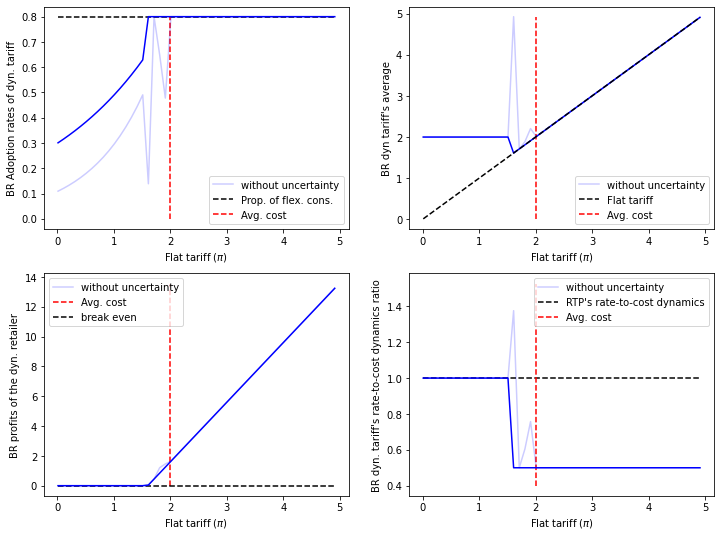

In [379]:
ind_neg = np.where(np.array(Gds)<0)[0]
pis_Gd_negs = pis[ind_neg]

fig,axs=plt.subplots(2,2,figsize=(12,9))

shares_new=beta*np.exp(-gamma*np.array(nus_new)/lamb)
axs[0,0].plot(pis,shares_new,color="blue")
axs[0,0].plot(pis,shares_without_uncertainty[::10],color="blue",alpha=0.2,label="without uncertainty")
axs[0,0].fill_between(pis_Gd_negs,0,0.8,color="gray",alpha=0.5)
axs[0,0].set_xlabel(r'Flat tariff ($\pi$)')
axs[0,0].set_ylabel("BR Adoption rates of dyn. tariff")
axs[0,0].hlines(beta,np.min(pis),np.max(pis),label='Prop. of flex. cons.',color='black',linestyle="dashed")
axs[0,0].vlines(cb,0,0.8,label='Avg. cost',color='red',linestyle="dashed")
axs[0,0].legend()

axs[0,1].plot(pis,pbs_new,color="blue")
axs[0,1].plot(pis,pbs_without_uncertainty[::10],color="blue",alpha=0.2,label="without uncertainty")
axs[0,1].set_xlabel(r'Flat tariff ($\pi$)')
axs[0,1].set_ylabel("BR dyn tariff's average")
axs[0,1].plot(pis,pis,color='black',linestyle="dashed",label='Flat tariff')
axs[0,1].fill_between(pis_Gd_negs,0,np.max(pis),color="gray",alpha=0.5)
axs[0,1].vlines(cb,np.min(pis),np.max(pis),label='Avg. cost',color='red',linestyle="dashed")
axs[0,1].legend()

axs[1,0].plot(pis,Gds_new,color="blue")
axs[1,0].plot(pis,Gds_without_uncertainty[::10],color="blue",alpha=0.2,label="without uncertainty")
axs[1,0].set_xlabel(r'Flat tariff ($\pi$)')
axs[1,0].set_ylabel("BR profits of the dyn. retailer")
axs[1,0].vlines(cb,np.min(Gds),np.max(Gds),label='Avg. cost',color='red',linestyle="dashed")
axs[1,0].hlines(0,np.min(pis),np.max(pis),color='black',linestyle="dashed",label="break even")
axs[1,0].fill_between(pis_Gd_negs,np.min(Gds),np.max(Gds),color="gray",alpha=0.5)
axs[1,0].legend()

rates_new = rate_new(nus_new,pis,cb,varc,lamb*np.ones(len(nus_new)),gamma)
axs[1,1].plot(pis,rates_new,color="blue")
axs[1,1].plot(pis,rates_without_uncertainty[::10],color="blue",label="without uncertainty",alpha=0.2)
axs[1,1].set_xlabel(r'Flat tariff ($\pi$)')
axs[1,1].set_ylabel("BR dyn. tariff's rate-to-cost dynamics ratio")
axs[1,1].hlines(1,np.min(pis),np.max(pis),color="black",linestyle="dashed",label="RTP's rate-to-cost dynamics")
axs[1,1].fill_between(pis_Gd_negs,np.min(rates),np.max(rates),color="gray",alpha=0.5)
axs[1,1].vlines(cb,0.8*np.min(rates),1.1*np.max(rates),label='Avg. cost',color='red',linestyle="dashed")
axs[1,1].legend()

plt.savefig(fold_fig+"uncertain_BR_dyn_sensib_pi.pdf")
plt.show()

In [380]:
def proportion_of_bad_dyn_cont(_pi,_nu,_lamb,_varc,_gam,_mu):
    lowbound = _gam*_nu
    upbound = _gam*_nu +8*_pi/_varc * _gam*(1-1/_mu)*((_lamb+(_gam-1)*_nu)/(_gam*_nu+_lamb))**2
    return np.clip(np.exp(-upbound/_lamb) - np.exp(-lowbound/_lamb),0,np.inf)

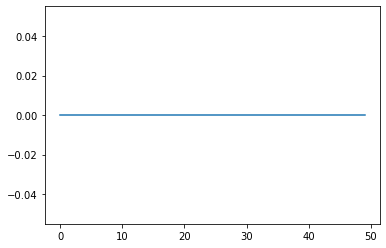

In [382]:
bads = [proportion_of_bad_dyn_cont(pis[i],nus_new[i],lamb,varc,gamma,mu) for i in range(len(nus_new))]
plt.plot(bads)

### BR flat retailer

In [383]:
cb0 = 2
Q=4
lamb=3
beta=0.8
mu=1.2
s2=1
gamma=gam(mu,s2)

In [384]:
def br_pi_new(_pb,_varp,_lamb,_cb0,_beta,_gam):
    mid_pi = _cb0 - _lamb*_varp/(2*_gam) + _lamb*_varp/(2*_gam) * np.real(lambertw(1/_beta * np.exp(1+_gam*2*(_pb-_cb0)/(_lamb*_varp))))
    pi_res = np.max([_cb0,np.min([_pb,mid_pi])])
    nu = 2*(_pb-pi_res)/_varp
    return pi_res, nu

def Gf_new(_Q,_pb,_varp,_lamb,_cb0,_beta,_gam):
    pi, nu = br_pi_new(_pb,_varp,_lamb,_cb0,_beta,_gam)
    if nu>=0:
        return (pi-_cb0)*_Q*(1-_beta+_beta*(1-np.exp(-_gam*nu/_lamb))),nu,pi
    else:
        return 0,nu,pi

In [385]:
varp=2
pbs = np.arange(0.1,cb0+3,0.1)

Gfs_new=[]
Gfs01_new=[]
Gfs10_new=[]
nus_new=[]
nus01_new=[]
nus10_new=[]
adops_new=[]
adops01_new=[]
adops10_new=[]
pis_new=[]
pis01_new=[]
pis10_new=[]
for pb in tqdm(pbs):
    gf,n,pii = Gf_new(Q,pb,varp,lamb,cb0,beta,gamma)
    Gfs_new.append(gf)
    nus_new.append(n)
    pis_new.append(pii)
    ad = 1-beta*np.exp(-gamma*n/lamb) if n >=0 else 0
    adops_new.append(ad)
    
    gf,n,pii = Gf_new(Q,pb,0.1,lamb,cb0,beta,gamma)
    Gfs01_new.append(gf)
    nus01_new.append(n)
    ad = 1-beta*np.exp(-gamma*n/lamb) if n >=0 else 0
    adops01_new.append(ad)
    pis01_new.append(pii)
    
    gf,n,pii = Gf_new(Q,pb,10,lamb,cb0,beta,gamma)
    Gfs10_new.append(gf)
    nus10_new.append(n)
    ad = 1-beta*np.exp(-gamma*n/lamb) if n >=0 else 0
    adops10_new.append(ad)
    pis10_new.append(pii)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<?, ?it/s]


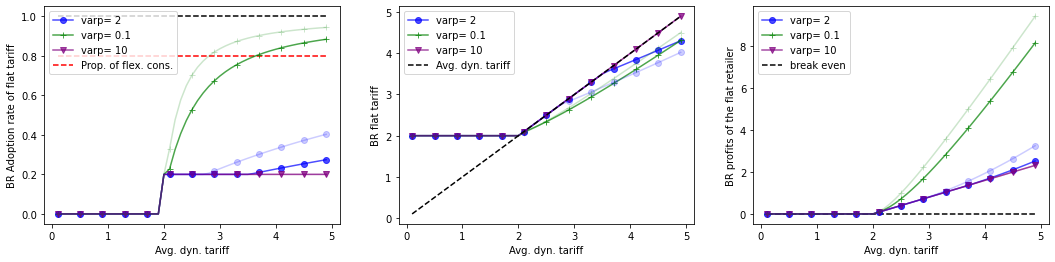

In [387]:
fig,axs=plt.subplots(1,3,figsize=(18,4))

axs[0].plot(pbs,adops_new,label="varp= 2",marker="o",color="blue",markevery=4,alpha=0.7)
axs[0].plot(pbs,adops01_new,label="varp= 0.1",marker="+",color="green",markevery=4,alpha=0.7)
axs[0].plot(pbs,adops10_new,label="varp= 10",marker="v",color="purple",markevery=4,alpha=0.7)
axs[0].plot(pbs,adops,marker="o",color="blue",markevery=4,alpha=0.2)
axs[0].plot(pbs,adops01,marker="+",color="green",markevery=4,alpha=0.2)
axs[0].plot(pbs,adops10,marker="v",color="purple",markevery=4,alpha=0.2)
axs[0].hlines(1,np.min(pbs),np.max(pbs),color="black",linestyle="dashed")
axs[0].hlines(beta,np.min(pbs),np.max(pbs),color="red",linestyle="dashed",label="Prop. of flex. cons.")
axs[0].set_xlabel("Avg. dyn. tariff")
axs[0].set_ylabel("BR Adoption rate of flat tariff")
axs[0].legend()

axs[1].plot(pbs,pis_new,label="varp= 2",marker="o",color="blue",markevery=4,alpha=0.7)
axs[1].plot(pbs,pis01_new,label="varp= 0.1",marker="+",color="green",markevery=4,alpha=0.7)
axs[1].plot(pbs,pis10_new,label="varp= 10",marker="v",color="purple",markevery=4,alpha=0.7)
axs[1].plot(pbs,pis_without_uncertainty,marker="o",color="blue",markevery=4,alpha=0.2)
axs[1].plot(pbs,pis01,marker="+",color="green",markevery=4,alpha=0.2)
axs[1].plot(pbs,pis10,marker="v",color="purple",markevery=4,alpha=0.2)
axs[1].plot(pbs,pbs,color='black',linestyle="dashed",label="Avg. dyn. tariff")
axs[1].set_xlabel("Avg. dyn. tariff")
axs[1].set_ylabel("BR flat tariff")
axs[1].legend()

axs[2].plot(pbs,Gfs_new,label="varp= 2",marker="o",color="blue",markevery=4,alpha=0.7)
axs[2].plot(pbs,Gfs01_new,label="varp= 0.1",marker="+",color="green",markevery=4,alpha=0.7)
axs[2].plot(pbs,Gfs10_new,label="varp= 10",marker="v",color="purple",markevery=4,alpha=0.7)
axs[2].plot(pbs,Gfs,marker="o",color="blue",markevery=4,alpha=0.2)
axs[2].plot(pbs,Gfs01,marker="+",color="green",markevery=4,alpha=0.2)
axs[2].plot(pbs,Gfs10,marker="v",color="purple",markevery=4,alpha=0.2)
axs[2].set_xlabel("Avg. dyn. tariff")
axs[2].set_ylabel("BR profits of the flat retailer")
axs[2].hlines(0,np.min(pbs),np.max(pbs),color='black',linestyle="dashed",label="break even")
axs[2].legend()
#plt.savefig(fold_fig+"uncertain_BR_flat_sensib_pb.pdf")
plt.show()

### Equilibrium

System's parameters:
 	 Q: 49.3416
 	 cb: 0.87917576041312
 	 cb0:0.87917576041312
 	 varc: 0.07020442264086002
 	 lambda: 0.5
 	 beta: 0.8


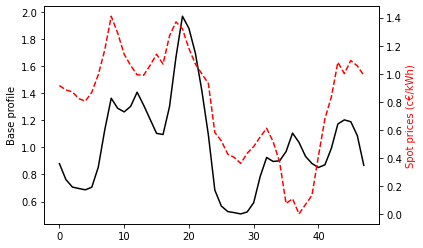

In [388]:
# Params system
lamb = 0.5
beta=0.8
mu=1.2
s2=1
gamma=gam(mu,s2)


#D=24h
days = ["01.11.24","07.02.24"]
Q=0
cb=0
for d in range(len(days)):
    Q += np.sum(Qdic[days[d]])
    cb += np.sum(Qdic[days[d]]*cdic[days[d]])
cb = cb/Q
cb0 = cb

c=np.zeros(24*len(days))
Qs=np.zeros(24*len(days))
for m in range(len(days)):
    for t in range(24):
        c[t+24*m]=cdic[days[m]][t]
        Qs[t+24*m]=Qdic[days[m]][t]
        
cms = np.zeros(len(days))
Qms = np.zeros(len(days))
for d in range(len(days)):
    Qms[d] = np.sum(Qdic[days[d]])
    cms[d] = np.sum(Qdic[days[d]]*cdic[days[d]])/Qms[d]
ext_cms = np.zeros(24*len(days))
for d in range(len(days)):
    for t in range(24):
        ext_cms[t+24*d] = cms[d]
    
varc = 0
for d in range(len(days)):
    for t in range(24):
        varc += Qs[t+24*d]*(c[t+24*d]**2 - ext_cms[t+24*d]**2)
varc=varc/Q

#cb=2
#varc=2

print("System's parameters:\n \t Q: %s\n \t cb: %s\n \t cb0:%s\n \t varc: %s\n \t lambda: %s\n \t beta: %s"%(Q,cb,cb0,varc,lamb,beta))


fig,ax1=plt.subplots()
ax1.plot(Qs,color='black')
ax1.set_ylabel("Base profile")
ax2=ax1.twinx()
ax2.plot(c,color='red',linestyle="dashed")
ax2.set_ylabel("Spot prices (c€/kWh)",color='red')
plt.show()

In [389]:
def convergence_new(_Q,_pb0,_varp0,_lamb,_cb0,_cb,_varc,_beta,_gam,NB_ITER,tol=1e-5):
    # containers
    pis = []
    pbs = []
    varps = []
    nu_flat = []
    nu_dyn = []
    prof_dyn = []
    prof_flat = []
    
    #Initialisation avec le RTP
    pbs.append(_pb0)
    varps.append(_varp0) 
    
    # Iterations des meilleures reponses
    for it in tqdm(range(NB_ITER)):
        proff, nf, pi = Gf_new(_Q,pbs[-1],varps[-1],_lamb,_cb0,_beta,_gam)
        nu_flat.append(nf)
        pis.append(pi)
        prof_flat.append(proff)
        profd, nd, pb = Gd_new(_Q,_cb,_varc,_lamb,pis[-1],_beta,_gam)
        nu_dyn.append(nd)
        pbs.append(pb)
        prof_dyn.append(profd)
        varps.append((alphatild(nd,_lamb,_gam))**2 / 4 * _varc)
        
        
        if it >5 and np.mean(np.abs(np.array(nu_dyn[-5:])-np.array(nu_flat[-5:]))) <= tol:
            print("Equilibrium reached - iteration %s / %s"%(it,NB_ITER))
            return np.array(pis), np.array(nu_flat), np.array(pbs), np.array(varps), np.array(nu_dyn),  np.array(prof_flat), np.array(prof_dyn)
        
    print("No equilibrium after %s iterations"%NB_ITER)
    return np.array(pis), np.array(nu_flat), np.array(pbs), np.array(varps), np.array(nu_dyn), np.array(prof_flat), np.array(prof_dyn)
    

In [390]:
pis_new, nu_flat_new, pbs_new, varps_new, nu_dyn_new, prof_flat_new, prof_dyn_new = convergence_new(Q,cb,2*varc,lamb,cb0,cb,varc,beta,gamma,200)

  3%|██▍                                                                               | 6/200 [00:01<00:42,  4.55it/s]

Equilibrium reached - iteration 6 / 200


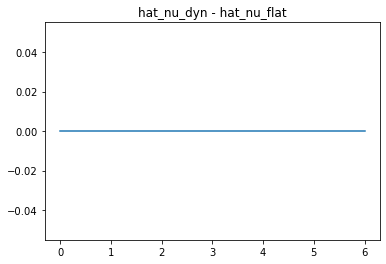

In [391]:
plt.figure()
plt.plot(nu_dyn_new-nu_flat_new)
plt.title("hat_nu_dyn - hat_nu_flat")
plt.show()

In [392]:
print(nu_dyn_new[-1])
print(nu_flat_new[-1])

0
0.0


In [393]:
print("Equilibrium:\n \t flat tariff : %s\n \t flat tariff avg cost: %s\n \t avg dyn tariff: %s\n \t dyn tariff-to-cost ratio: %s\n \t dyn adoption rate: %s  "%(pis_new[-1],cb0,pbs_new[-1],0.5*alphatild(nu_dyn_new[-1],lamb,gamma), beta*np.exp(-gamma*nu_flat_new[-1]/lamb)))


Equilibrium:
 	 flat tariff : 0.87917576041312
 	 flat tariff avg cost: 0.87917576041312
 	 avg dyn tariff: 0.87917576041312
 	 dyn tariff-to-cost ratio: 0.5
 	 dyn adoption rate: 0.8  


In [394]:
def dyn_tariff_profile_new(_pb,_nu,_lamb,_c,_cms,_gam):
    profile = np.zeros(24*len(days))
    for d in range(len(days)):
        for t in range(24):
            profile[t+24*d] = alphatild(_nu,_lamb,_gam) * 0.5 * (_c[t+24*d]-_cms[d]) + _pb
    return profile

def net_revenues_profile_dyn_new(tariff_profile,_c,_nu,_lamb,_gam):
    profile = np.zeros(24*len(days))
    tariff_m = np.zeros(len(days))
    for d in range(len(days)):
        tariff_m[d] = np.sum(tariff_profile[24*d:24*(d+1)-1]*Qs[24*d:24*(d+1)-1])/Qms[d]
    share_flex = beta*np.exp(-_gam*_nu/_lamb)
    exp_flex = beta*(_gam*_nu+_lamb)*np.exp(-_gam*_nu/_lamb)
    for d in range(len(days)):
        for t in range(24):
            profile[t+24*d] = Qs[t+24*d]*(tariff_profile[t+24*d]-_c[t+24*d])*share_flex - exp_flex*Qs[t+24*d]*(tariff_profile[t+24*d]-_c[t+24*d])*(tariff_profile[t+24*d]-tariff_m[d])
    return profile

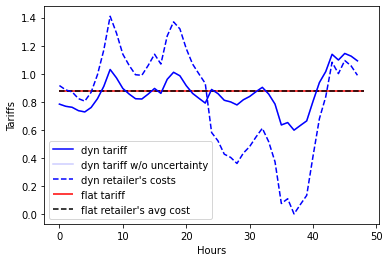

In [395]:
ps_new = dyn_tariff_profile_new(pbs_new[-1],nu_dyn_new[-1],lamb,c,cms,gamma)
pms_new = np.zeros(len(days))
for d in range(len(days)):
    pms_new[d] = np.sum(ps_new[24*d:24*(d+1)-1]*Qs[24*d:24*(d+1)-1])/Qms[d]
ext_pms_new = np.zeros(24*len(days))
for d in range(len(days)):
    for t in range(24):
        ext_pms_new[t+24*d] = pms_new[d]
plt.figure()
plt.plot(ps_new,label="dyn tariff",color="blue")
plt.plot(ps,label="dyn tariff w/o uncertainty",color="blue",alpha=0.2)
plt.hlines(pis_new[-1],0,24*len(days),label="flat tariff",color="red")
plt.plot(c,label="dyn retailer's costs",color="blue",linestyle="dashed")
plt.hlines(cb0,0,24*len(days),label="flat retailer's avg cost",color="black",linestyle="dashed")
plt.xlabel("Hours")
plt.ylabel("Tariffs")
plt.legend()
#plt.savefig(fold_fig+"equilibrium_tariff_equal_scosts.pdf")
plt.show()

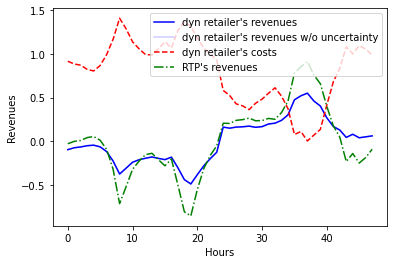

In [396]:
revenues_new = net_revenues_profile_dyn_new(ps_new,c,nu_dyn_new[-1],lamb,gamma)
plt.figure()
plt.plot(revenues_new,label="dyn retailer's revenues",color="blue")
plt.plot(revenues,label="dyn retailer's revenues w/o uncertainty",color="blue",alpha=0.2)
plt.plot(c,label="dyn retailer's costs",color="red",linestyle="dashed")
plt.plot(Qs*(np.sum(revenues_new)/Q+cb-c),label="RTP's revenues",color="green",linestyle="-.")
plt.legend()
plt.xlabel("Hours")
plt.ylabel("Revenues")
#plt.savefig(fold_fig+"equilibrium_revenues_equal_scosts.pdf")
plt.show()

In [397]:
print("Revenu total du retailer dynamique: %.2f"%np.sum(revenues_new))
print("Ecart type du revenu instantanné en pourcentage du revenu: %.2f pct"%(np.std(revenues_new)/np.sum(revenues_new) *100))
print("Ecart type d'un revenu flat a cb en pourcentage du revenu (revenu egal): %.2f pct"%(np.std(Qs*(np.sum(revenues_new)/Q+cb-c))/np.sum(revenues_new) *100))

Revenu total du retailer dynamique: 0.30
Ecart type du revenu instantanné en pourcentage du revenu: 84.05 pct
Ecart type d'un revenu flat a cb en pourcentage du revenu (revenu egal): 131.59 pct


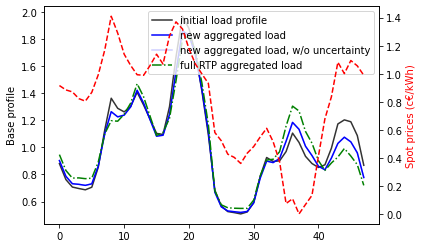

In [399]:
modif_load_new = aggregate_load(ps_new,pms_new,nu_dyn_new[-1],lamb)
full_rtp = full_RTP_load(c,cms,lamb)
fig,ax1=plt.subplots()
ax1.plot(Qs,color='black',alpha=0.8,label="initial load profile")
ax1.plot(modif_load_new,color="blue",label="new aggregated load")
ax1.plot(modif_load,color="blue",label="new aggregated load, w/o uncertainty",alpha=0.2)
ax1.plot(full_rtp,color="green",linestyle="-.",label="full RTP aggregated load")
ax1.set_ylabel("Base profile")
ax2=ax1.twinx()
ax2.plot(c,color='red',linestyle="dashed")
ax2.set_ylabel("Spot prices (c€/kWh)",color='red')
ax1.legend()
#plt.savefig(fold_fig+"equilibrium_load_equal_scosts.pdf")
plt.show()
    

    

In [400]:
print("Ecart type de la charge en pct de la charge totale: \n\t initiale : %.2f\n\t en competition: %.2f\n\t full RTP: %.2f"%(np.std(Qs)/Q*100,np.std(modif_load_new)/Q*100,np.std(full_rtp)/Q*100))

Ecart type de la charge en pct de la charge totale: 
	 initiale : 0.70
	 en competition: 0.66
	 full RTP: 0.65


In [401]:
coeffs = np.arange(0.01,2,0.1)
nu_fin_flat_new = np.zeros(len(coeffs))
nu_fin_dyn_new = np.zeros(len(coeffs))

for i,coeff in enumerate(coeffs):
    pis, nu_flat_new, pbs, varps, nu_dyn_new, prof_flat, prof_dyn = convergence_new(Q,cb,2*varc,lamb,cb*coeff,cb,varc,beta,gamma,100)
    nu_fin_flat_new[i] = nu_flat_new[-1]
    nu_fin_dyn_new[i] = nu_dyn_new[-1]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


No equilibrium after 100 iterations


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.51it/s]


No equilibrium after 100 iterations


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.10it/s]


No equilibrium after 100 iterations


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.72it/s]


No equilibrium after 100 iterations


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:50<00:00,  1.96it/s]


No equilibrium after 100 iterations


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.82it/s]


No equilibrium after 100 iterations


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.40it/s]


No equilibrium after 100 iterations


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.49it/s]


No equilibrium after 100 iterations


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.10it/s]


No equilibrium after 100 iterations


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.28it/s]


No equilibrium after 100 iterations


  6%|████▉                                                                             | 6/100 [00:01<00:28,  3.33it/s]


Equilibrium reached - iteration 6 / 100


  6%|████▉                                                                             | 6/100 [00:01<00:27,  3.40it/s]


Equilibrium reached - iteration 6 / 100


  6%|████▉                                                                             | 6/100 [00:01<00:28,  3.31it/s]


Equilibrium reached - iteration 6 / 100


  6%|████▉                                                                             | 6/100 [00:01<00:28,  3.31it/s]


Equilibrium reached - iteration 6 / 100


  6%|████▉                                                                             | 6/100 [00:01<00:29,  3.22it/s]


Equilibrium reached - iteration 6 / 100


  6%|████▉                                                                             | 6/100 [00:01<00:27,  3.37it/s]


Equilibrium reached - iteration 6 / 100


  6%|████▉                                                                             | 6/100 [00:01<00:26,  3.53it/s]


Equilibrium reached - iteration 6 / 100


  6%|████▉                                                                             | 6/100 [00:01<00:28,  3.30it/s]


Equilibrium reached - iteration 6 / 100


  6%|████▉                                                                             | 6/100 [00:02<00:31,  2.96it/s]


Equilibrium reached - iteration 6 / 100


  6%|████▉                                                                             | 6/100 [00:01<00:28,  3.30it/s]

Equilibrium reached - iteration 6 / 100


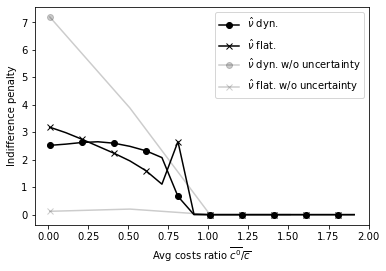

In [405]:
plt.figure()
plt.plot(coeffs,nu_fin_dyn_new,label=r'$\hat{\nu}$ dyn.',color="black",marker="o",markevery=2)
plt.plot(coeffs,nu_fin_flat_new,label=r'$\hat{\nu}$ flat.',color="black",marker="x",markevery=2)
plt.plot(coeffs[::5],nu_fin_dyn,label=r'$\hat{\nu}$ dyn. w/o uncertainty',color="black",marker="o",markevery=2,alpha=0.2)
plt.plot(coeffs[::5],nu_fin_flat,label=r'$\hat{\nu}$ flat. w/o uncertainty',color="black",marker="x",markevery=2,alpha=0.2)
plt.xlabel(r'Avg costs ratio $\overline{c^0}/\overline{c}$')
plt.ylabel("Indifference penalty")
plt.legend()
plt.savefig(fold_fig+"uncertain_nu_eq_cost_ratio.pdf")
plt.show()